# Austin Animal Center Intakes Analysis

The [Austin Animal Center](http://www.austintexas.gov/department/aac), the largest no-kill municipal shelter in the United States, makes available its collected data on [Austin's Open Data Portal](https://data.austintexas.gov/). This data includes both animals [incoming into the shelter](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) and the [animals' outcome](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238). In this post, we perform some exploratory data analysis on the intakes dataset to see if we can find any noticeable trends or interesting pieces of information of the data. First, we will extract the data from Austin's Data Portal, which is supported by [Socrata](https://socrata.com/). We will then perform some data transformation and cleaning steps to get the data ready for analysis.

## Getting Started

Before diving in, import the libraries that we will use throughout the analysis. [`%matplotlib inline`](http://ipython.readthedocs.io/en/stable/interactive/plotting.html) is used for displaying the visualizations.

In [1]:
%matplotlib inline

import requests
import pandas as pd
import numpy as np
import seaborn as sns
from urllib.error import HTTPError
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

## Extracting the Animal Intakes Dataset

The Socrata Open Data Access (SODA) API is used to extract the data from the Open Data Portal. The Socrata API documentation states there is a [call limit](https://dev.socrata.com/docs/paging.html) to minimize the impact on their servers. Therefore, we need to page the results to collect the entire dataset. The following function extracts the data from the API and transforms the default JSON result format into a pandas DataFrame when the `return_df` parameter is set to `True`.

In [2]:
def get_soda_api_data(endpoint, count=1000, offset=0, return_df=True):
    params = {'$limit': count, '$offset': offset}
    
    results = []

    while True:

        try:
            r = requests.get(endpoint, params=params)
            rcontent = r.json()

            if rcontent == []:
                break

            results.append(rcontent)
            offset += count
            params['$offset'] = offset

        except HTTPError as err:

            if err.response.status_code == '404':
                break
            else:
                print(err.response.status_code)
    
    if return_df:
        results_df = pd.DataFrame()

        for i in results:
            results_df = results_df.append(pd.io.json.json_normalize(i))
        
        return results_df
    
    else:
        return results

The intakes dataset API endpoint can be found in the upper-right corner of the [dataset's information page](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) by clicking the API button and copying the URL endpoint. The data can also be downloaded as a CSV by changing the JSON output to CSV. 

With the endpoint in hand, we can use our new function to get the intakes dataset! When the data has been paged through and collected into a DataFrame, we print the number of rows and the first five rows of the dataset using [`head()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html) to make sure we successfully extracted the data.

In [3]:
intakes_endpoint = 'https://data.austintexas.gov/resource/fdzn-9yqv.json'

intakes_df = get_soda_api_data(intakes_endpoint)

print(intakes_df.shape)
intakes_df.head()

(80187, 12)


,age_upon_intake,animal_id,animal_type,breed,color,datetime,datetime2,found_location,intake_condition,intake_type,name,sex_upon_intake
0,8 years,A706918,Dog,English Springer Spaniel,White/Liver,2015-07-05T12:59:00.000,2015-07-05T12:59:00.000,9409 Bluegrass Dr in Austin (TX),Normal,Stray,Belle,Spayed Female
1,11 months,A724273,Dog,Basenji Mix,Sable/White,2016-04-14T18:43:00.000,2016-04-14T18:43:00.000,2818 Palomino Trail in Austin (TX),Normal,Stray,Runster,Intact Male
2,4 weeks,A665644,Cat,Domestic Shorthair Mix,Calico,2013-10-21T07:59:00.000,2013-10-21T07:59:00.000,Austin (TX),Sick,Stray,NaN,Intact Female
3,4 years,A682524,Dog,Doberman Pinsch/Australian Cattle Dog,Tan/Gray,2014-06-29T10:38:00.000,2014-06-29T10:38:00.000,800 Grove Blvd in Austin (TX),Normal,Stray,Rio,Neutered Male
4,2 years,A743852,Dog,Labrador Retriever Mix,Chocolate,2017-02-18T12:46:00.000,2017-02-18T12:46:00.000,Austin (TX),Normal,Owner Surrender,Odin,Neutered Male


The dataset contains just over 80k rows and twelve columns, which matches the information on the dataset's open data portal page. The column names all match what is listed on the information page as well. Therefore we have successfully extracted the data programmatically! Now that we have the data in a tidy pandas DataFrame let's save it to a CSV using pandas' convenient [`to_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html) IO method, so we don't have to call and get the data from the Socrata API repeatedly.

In [4]:
intakes_df.to_csv('../../../datasets/austin animal center intake outcomes/aac_intakes.csv', 
                  encoding='utf-8', index=False)

With the data extracted and saved so we can access it later if needed, we can move to transforming and cleaning the data!

## Feature Engineering and Data Preparation

Although the dataset we have now is tidy already, there are a few more steps we can take to make the data more useful in what is collectively referred to as feature engineering. The process of feature engineering can often be a manual task, but the addition of more data points given the information already available can be a powerful way of enhancing a dataset's information. We know from the dataset's information that each row represents an individual intake record. Thus we can also add a count column for convenience.

In [5]:
intakes_df['count'] = 1

The ages of the animals entering the shelter are given by a numeric value and unit of time, for example, '1 year', '3 months', or '18 weeks'. In most cases, estimated age is the best available due to the circumstance of the shelter environment, but the current format is not very suitable for analysis. Therefore, we convert the approximated age given by the `age_upon_intake` column into the number of days which allows us to get a numeric value of the animals' age that can be transformed into a consistent unit of time, such as years. The datetime column is also transformed to a usable datetime format using [`pd.to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html). The following are some simple functions that take the DataFrame and the respective age and date columns as arguments. 

In [6]:
def transform_age(df, age_column):
    df = df.loc[df.loc[:, age_column] != 'NULL']
    
    range_column = age_column + '_Period Range'
    
    df[age_column + '_Periods'], df[range_column] = df.loc[:, age_column].str.split(' ').str[0].fillna(0).astype(int), df.loc[:, age_column].str.split(' ').str[1].fillna(0)
    
    
    df[range_column] = np.where(df[range_column].str.contains('day'), 1, 
                                  np.where(df[range_column].str.contains('week'), 7, 
                                           np.where(df[range_column].str.contains('month'), 30, 
                                                    np.where(df[range_column].str.contains('year'), 365, 0)))).astype(int)

    df[age_column + '_(days)'] = df[range_column] * df[age_column + '_Periods']
    df[age_column + '_(years)'] = df[age_column + '_(days)'] / 365
    
    df[age_column + '_age_group'] = pd.cut(df[age_column + '_(years)'], 10)

    return df


def transform_date(df, event):
    event_date = event + '_datetime'
    df[event_date] = pd.to_datetime(df['datetime'])

    df[event + '_month'] = df[event_date].dt.month
    df[event + '_year'] = df[event_date].dt.year
    df[event + '_monthyear'] = df[event + '_datetime'].dt.to_period('M')
    
    df[event + '_weekday'] = df[event_date].dt.weekday_name
    df[event + '_hour'] = df[event_date].dt.hour
    
    df.rename(columns={event + '_name': 'name'}, inplace=True)
    
    return df

Use the above functions to transform the date and age columns and add some more informative columns that will be used for exploring the data.

In [7]:
intakes_df = transform_age(intakes_df, 'age_upon_intake')
intakes_df = transform_date(intakes_df, 'intake')

Print the resulting shape of the new DataFrame with the additional columns and the first five rows.

In [8]:
print(intakes_df.shape)
intakes_df.head()

(80187, 24)


,age_upon_intake,animal_id,animal_type,breed,color,datetime,datetime2,found_location,intake_condition,intake_type,...,age_upon_intake_Period Range,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour
0,8 years,A706918,Dog,English Springer Spaniel,White/Liver,2015-07-05T12:59:00.000,2015-07-05T12:59:00.000,9409 Bluegrass Dr in Austin (TX),Normal,Stray,...,365,2920,8.000000,"(7.5, 10.0]",2015-07-05 12:59:00,7,2015,2015-07,Sunday,12
1,11 months,A724273,Dog,Basenji Mix,Sable/White,2016-04-14T18:43:00.000,2016-04-14T18:43:00.000,2818 Palomino Trail in Austin (TX),Normal,Stray,...,30,330,0.904110,"(-0.025, 2.5]",2016-04-14 18:43:00,4,2016,2016-04,Thursday,18
2,4 weeks,A665644,Cat,Domestic Shorthair Mix,Calico,2013-10-21T07:59:00.000,2013-10-21T07:59:00.000,Austin (TX),Sick,Stray,...,7,28,0.076712,"(-0.025, 2.5]",2013-10-21 07:59:00,10,2013,2013-10,Monday,7
3,4 years,A682524,Dog,Doberman Pinsch/Australian Cattle Dog,Tan/Gray,2014-06-29T10:38:00.000,2014-06-29T10:38:00.000,800 Grove Blvd in Austin (TX),Normal,Stray,...,365,1460,4.000000,"(2.5, 5.0]",2014-06-29 10:38:00,6,2014,2014-06,Sunday,10
4,2 years,A743852,Dog,Labrador Retriever Mix,Chocolate,2017-02-18T12:46:00.000,2017-02-18T12:46:00.000,Austin (TX),Normal,Owner Surrender,...,365,730,2.000000,"(-0.025, 2.5]",2017-02-18 12:46:00,2,2017,2017-02,Saturday,12


## Exploratory Data Analysis of the Animal Intakes Dataset

Before beginning, we quickly set the overall style of the plots that will be created throughout the analysis.

In [9]:
sns.set(style="white", context="talk", font_scale=2)

Now that the extracted raw dataset has been transformed with additional features and information, we can begin exploring the data! First, let's get a sense of the proportion of different intake conditions and types, as well as the age and type of the animal entering the shelter.

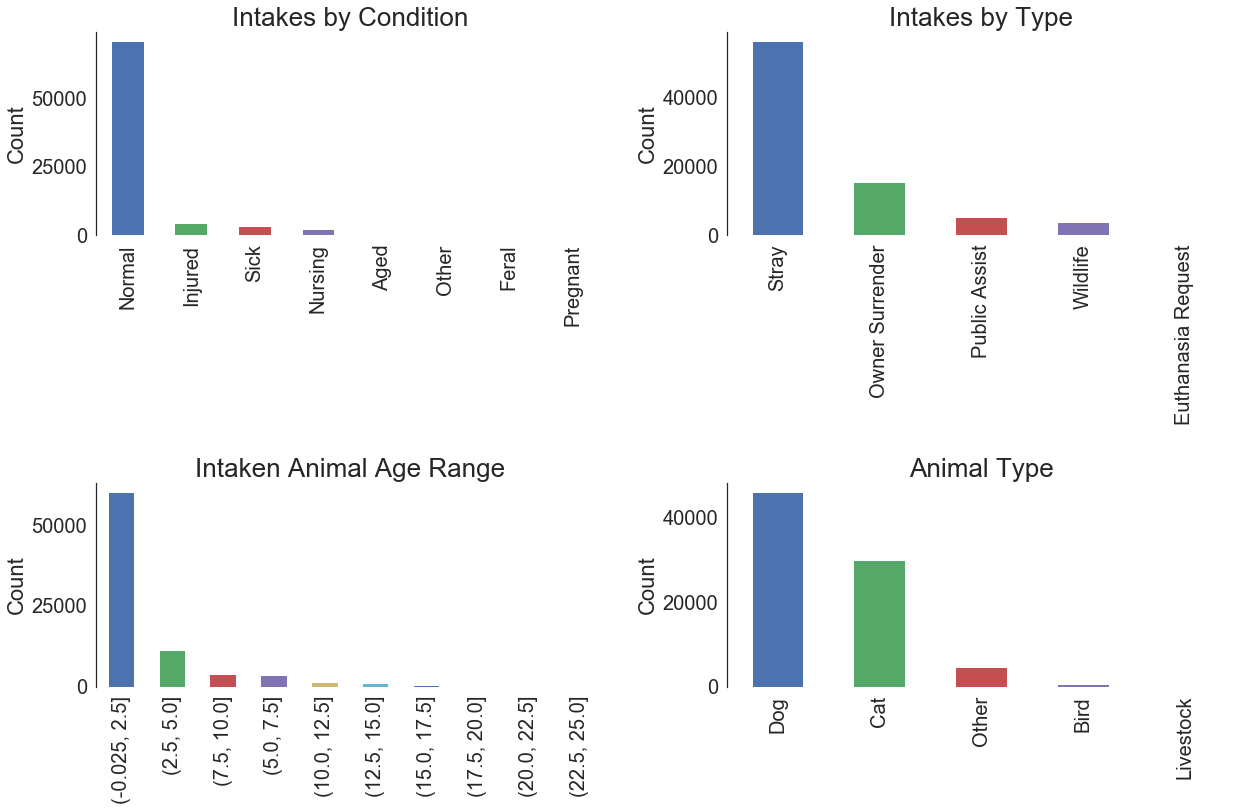

In [10]:
f, ax = plt.subplots(2, 2, figsize=(18, 12))

p1 = intakes_df['intake_condition'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0,0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Intakes by Condition', fontsize=26)

p2 = intakes_df['intake_type'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0,1])
p2.set_ylabel('Count', fontsize=22)
p2.set_title('Intakes by Type', fontsize=26)

p3 = intakes_df['age_upon_intake_age_group'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1,0])
p3.set_ylabel('Count', fontsize=22)
p3.set_title('Intaken Animal Age Range', fontsize=26)

p4 = intakes_df['animal_type'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1,1])
p4.set_ylabel('Count', fontsize=22)
p4.set_title('Animal Type', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)

We see the majority of animals entering the shelter are strays without any injuries or illness and approximately within 2.5 years of age. Owner surrenders are the next most common intake type, which can occur for a variety of reasons such as a significant life change or a death in the family but is entirely behind strays. Dogs and cats are by far the most common animals to be brought to the shelter, perhaps to no one's surprise. What is also interesting is the vast disparity between the age of the animal entering the shelter. As dogs and cats have approximately the same average lifespan, would we have expected to see a more even distribution of ages? Or, are younger dogs and cats more likely to be picked up as strays? One could likely reason those younger animals would make up a higher proportion of strays, especially for cats.

Knowing that the overwhelming majority of animals entering the shelter are relatively healthy strays within 2.5 years of age and are either a dog or cat, is it likely most of these animals are intact (not neutered or spayed)? As cat overpopulation (especially in perpetually warm and temperate climates like Austin and the surrounding area) is likely a concern and trap neuter release programs become more common, would we expect to see more intact cats entering the shelter than dogs?

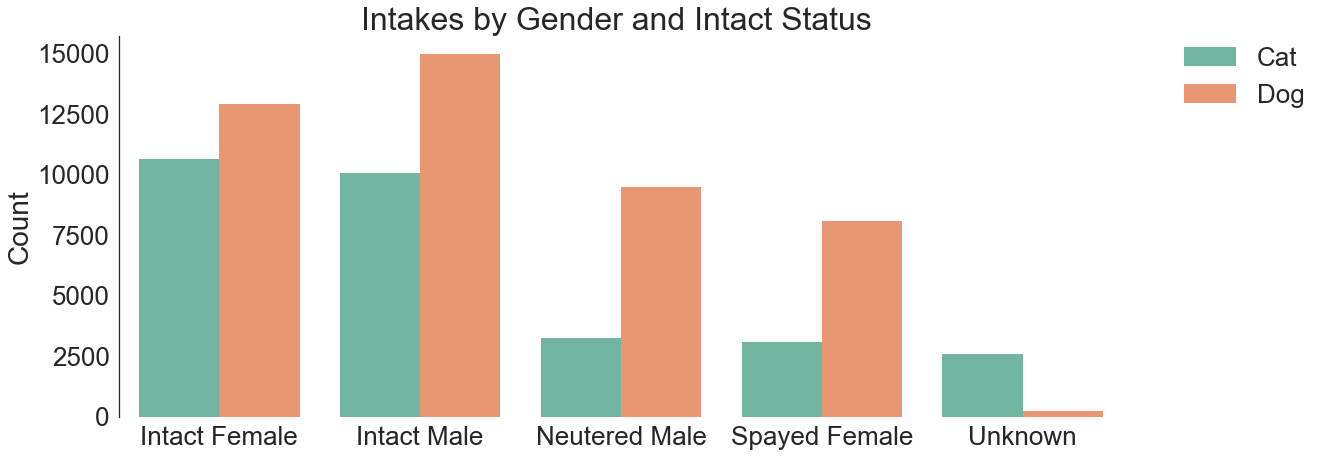

In [11]:
plt.figure(figsize=(18, 7))

intaken_animals = intakes_df.groupby(['animal_type', 'sex_upon_intake'])['count'].sum().reset_index()

intaken_animals = intaken_animals.loc[(intaken_animals['animal_type'] == 'Dog') | 
                                      (intaken_animals['animal_type'] == 'Cat')].loc[(intaken_animals['sex_upon_intake'] != 'NULL')]


bar = sns.barplot(x='sex_upon_intake', y='count', hue='animal_type', data=intaken_animals, 
                 palette=sns.color_palette("Set2", 10))

bar.set_title('Intakes by Gender and Intact Status ', fontsize=32)
bar.set_ylabel('Count', fontsize=28)
bar.axes.xaxis.label.set_visible(False)

bar.xaxis.labelpad = 10
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Intact dogs enter the shelter at a slightly higher volume than cats; however, notice neutered cats enter the shelter at a much lower amount than dogs, which could indicate that when a cat does enter the shelter, it is more likely to be intact then spayed or neutered, which fits into our previous assumptions. 

Are there any significant differences in the number of animals intaken at particular periods of time, such as the day of week or month of the year? 

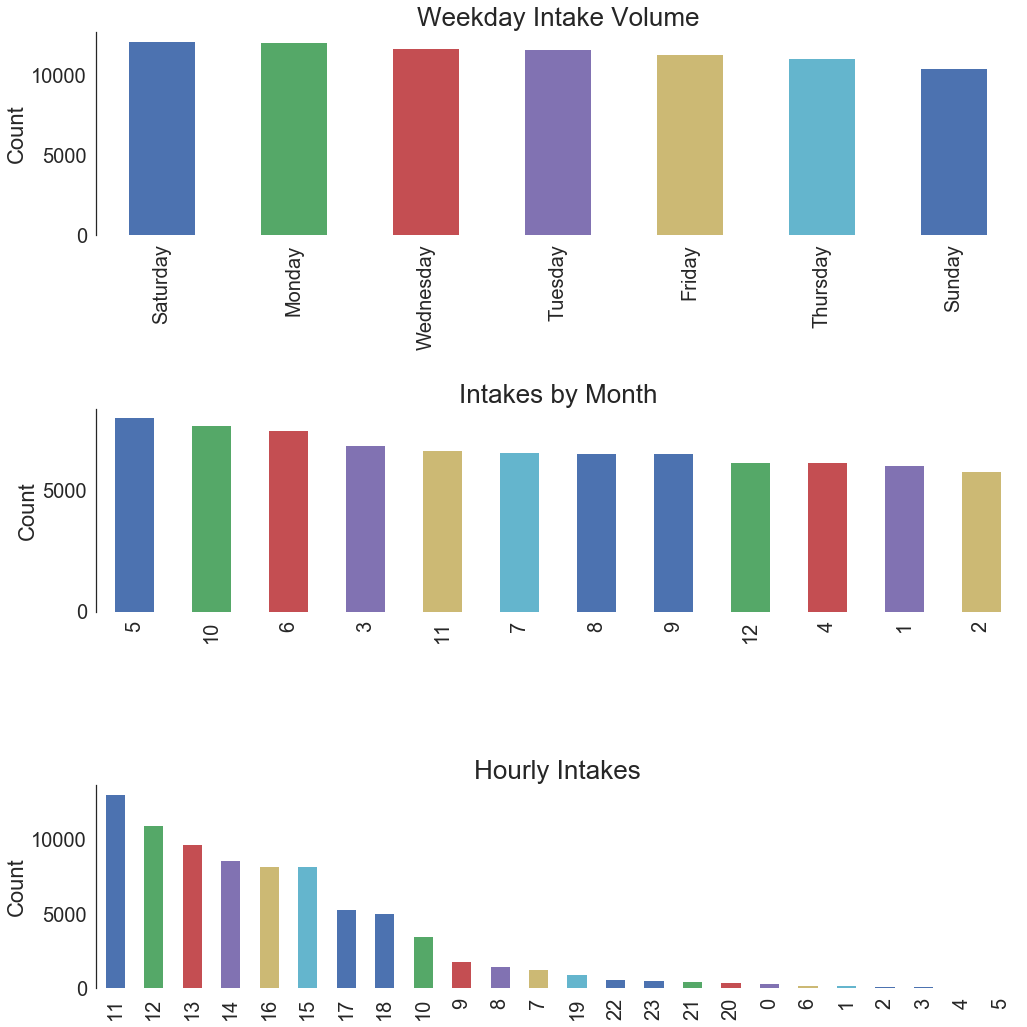

In [12]:
f, ax = plt.subplots(3, 1, figsize=(15, 15))

p1 = intakes_df['intake_weekday'].value_counts().plot(kind='bar', fontsize=20, ax=ax[0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Weekday Intake Volume', fontsize=26)

p2 = intakes_df['intake_month'].value_counts().plot(kind='bar', fontsize=20, ax=ax[1])
p2.set_ylabel('Count', fontsize=22)
p2.set_title('Intakes by Month', fontsize=26)

p3 = intakes_df['intake_hour'].value_counts().plot(kind='bar', fontsize=20, ax=ax[2])
p3.set_ylabel('Count', fontsize=22)
p3.set_title('Hourly Intakes', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)

There isn't much difference in volume depending on the day of the week, with perhaps the exception of Sunday. May through June and October through November are the busiest times of the year based on overall animal intake volume. Cats most commonly begin having litters in early spring, peaking in late spring and ending in the fall, according to the [Humane Society of America](http://www.humanesociety.org/animals/cats/facts/kitten_season.html) which roughly aligns to the most active months of the year. Dogs do not have a 'breeding season' per se. Therefore it may be more difficult to determine if months with more intakes are caused by dogs giving birth to litters of puppies.

We see a much more substantial distinction between the volume of intakes at the hourly level, where a large proportion of intakes occur from 11 am - 2 pm. This volume likely coincides with the shelter's opening hours as the amount tapers throughout the day and we see very few intakes made after 8 pm.

As we have about four years' worth of data, let's plot the number and types of animal intakes over time to see if there are any noticeable trends or other points of interest. We noted stray animal intakes are by far the most common intake. Therefore, an additional plot is created without strays to get a better sense of the trend for the other intake types.

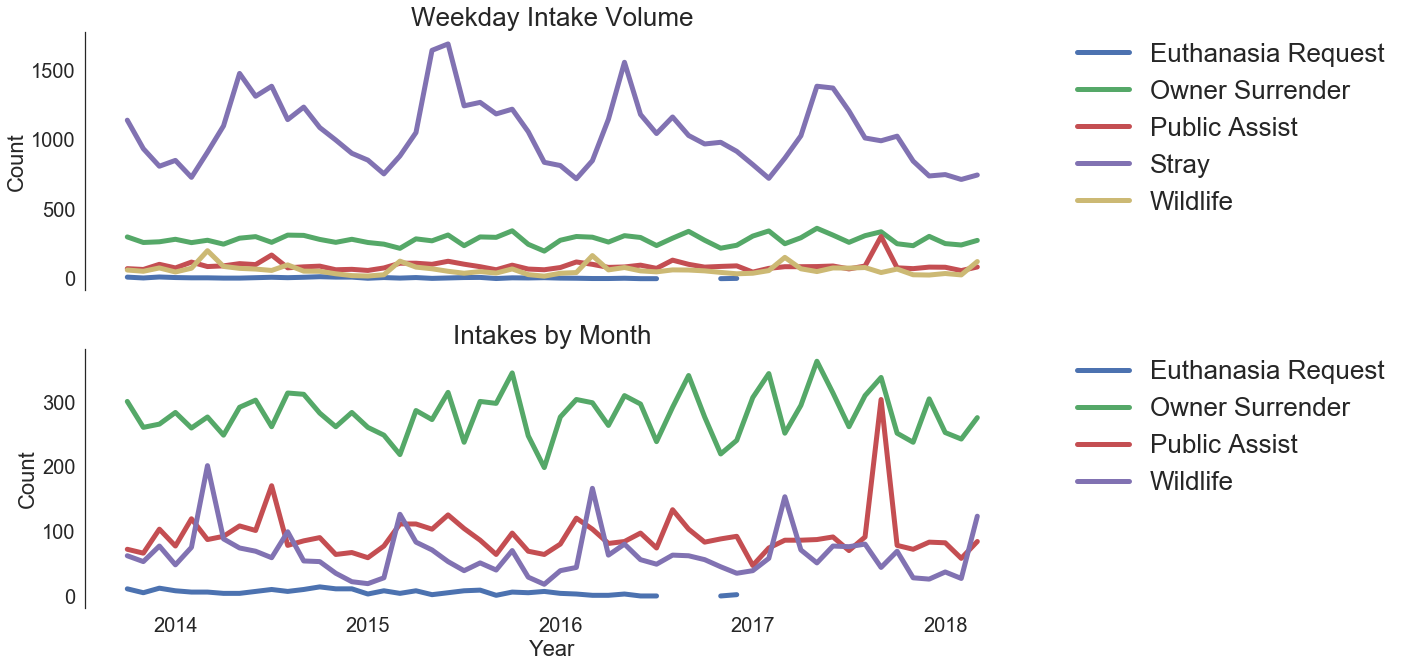

In [13]:
f, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

intakes_time = pd.pivot_table(intakes_df, 
                              index=['intake_monthyear'], columns=['intake_type'], 
                              values='count', aggfunc=np.sum)

intakes_nostray = intakes_time.copy()
del intakes_nostray['Stray']

p1 = intakes_time.plot(kind='line', linewidth=5, fontsize=20, ax=ax[0])
p1.set_ylabel('Count', fontsize=22)
p1.set_title('Weekday Intake Volume', fontsize=26)

p2 = intakes_nostray.plot(kind='line', linewidth=5, fontsize=20, ax=ax[1])
p2.set_ylabel('Count', fontsize=22)
p2.set_xlabel('Year', fontsize=22)
p2.set_title('Intakes by Month', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

It seems stray animal intakes peak in the first half of the year around April-May and then steadily tapers off until the next year. This result appears interesting as one could reasonably assume that stray animal intakes would be consistent throughout the year as pets go missing and strays are picked up through various trap-neuter-release and other programs. The peaks could be a result of animals giving birth and thereby increasing the number of strays that would be picked up. This result would align when 'cat breeding season' (though there isn't technically such a term), starts to pick up in the spring, as we noted earlier. There is a slight downward trend to the number of strays taken in each year, which could be construed as positive (more resources and efficient programs, for example), or negative (lack of resources means more strays are still on the street and not taken to the shelter). 2018 appears to be a meager year regarding stray intakes, hopefully for the former reason.

Although much less significant in overall volume compared to strays, wildlife intakes appear to have a similar trend to stray intakes, peaking in the first months of the year and then steadily decreasing. Owner surrender intakes dip and rise rather frequently, perhaps there are certain parts of the month when owner surrenders are more common. Public assistance intakes look to be the most consistent regarding volume; however, there is an interesting spike in the latter half of 2017.

Earlier, we noted there wasn't much difference in the number of intakes by day of the week, but does this hold for owner surrenders? Given surrenders are from people outside the shelter organization, would we see more surrenders on weekends?

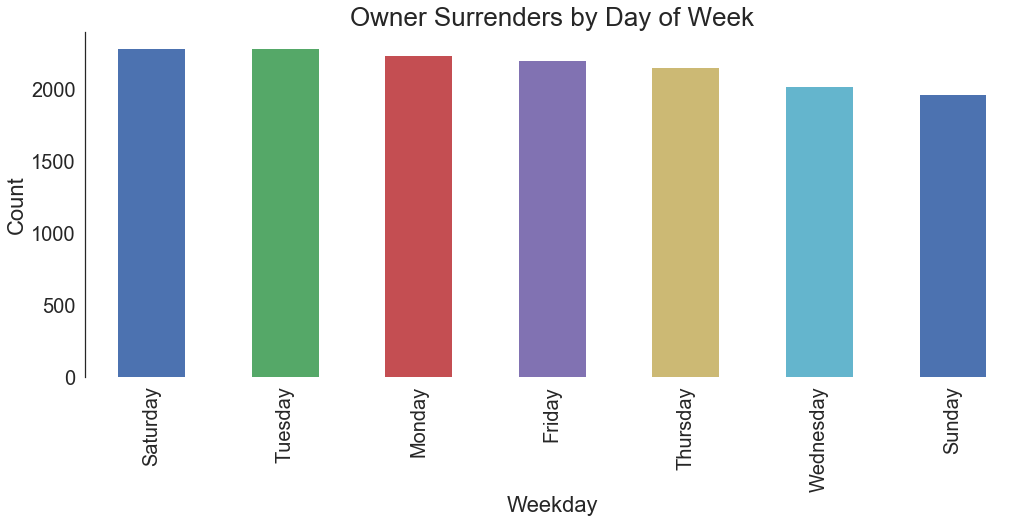

In [14]:
surrender_weekday = intakes_df.loc[intakes_df['intake_type'] == 'Owner Surrender']['intake_weekday'].value_counts().plot(kind='bar', 
                                                                                                                         fontsize=20, 
                                                                                                                         figsize=(15, 8))
surrender_weekday.set_ylabel('Count', fontsize=22)
surrender_weekday.set_xlabel('Weekday', fontsize=22)
surrender_weekday.set_title('Owner Surrenders by Day of Week', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)

The days with the most owner surrender intakes are rather similar to the overall volume of intakes during the week and do not differ much from each other. Given that people with all types of schedules own pets, these results are not surprising, though our original guess of more owner surrenders during the weekend turned out to be a false assumption. The owner surrender intake volume would also be bounded by the operating hours of the shelter.

Investigating further into the trend of owner surrenders, let's plot only surrenders from the beginning of 2017 by month.

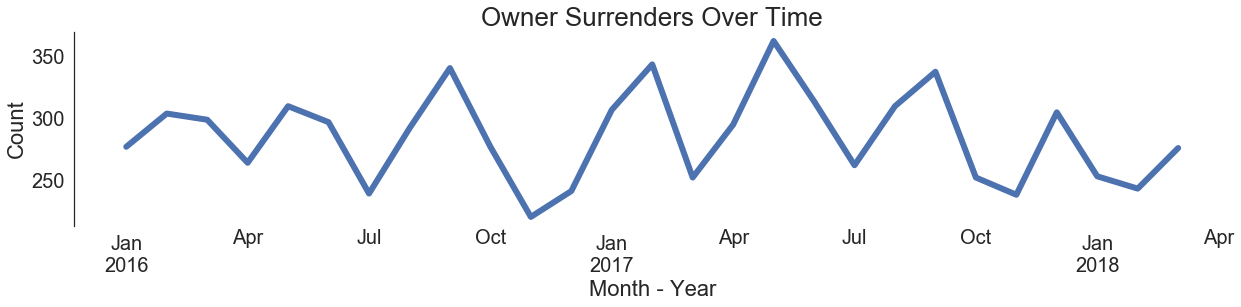

In [15]:
surr_over_time = intakes_time.loc[intakes_time.index >= '2016-01-01']['Owner Surrender'].plot(kind='line', 
                                                                                              linewidth=6,
                                                                                              fontsize=20,
                                                                                              figsize=(18, 5))

surr_over_time.set_ylabel('Count', fontsize=22)
surr_over_time.set_xlabel('Month - Year', fontsize=22)
surr_over_time.set_title('Owner Surrenders Over Time', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)

Peaks appear to occur in January, February, May, August, September, and December. What could be some causes of this trend? Knowing that owner surrenders increase in the winter months January, February, and December, one possible reason that comes to mind is owners surrendering animals received as gifts over the holidays (a terrible idea, by the way!). August and September are about when cat breeding typically decreases. Thus, one explanation could be that kittens that were adopted at the beginning of kitten season in early April would be adults at that point. If not appropriately trained, kittens can develop several behavioral issues into adulthood. Perhaps the owners who adopted kittens did not want the cat after it became an adult? A depressing hypothesis, to be sure.

Let's quickly check to see if there's any significant difference in the number of intakes at the beginning and end of the month compared to the rest of the month. We use pandas's datetime functions [`dt.is_month_start`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.dt.is_month_start.html) and [`dt.is_month_end`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.dt.is_month_end.html) and find the average of the number of intakes.

In [16]:
intakes_df['month_start_end'] = np.where(intakes_df['intake_datetime'].dt.is_month_start, 'Start', 
                                        np.where(intakes_df['intake_datetime'].dt.is_month_end, 'End', 'Middle'))

intakes_df.groupby(['intake_datetime', 'month_start_end'])['count'].sum().groupby('month_start_end').mean()

month_start_end
End       1.411732
Middle    1.404025
Start     1.439012
Name: count, dtype: float64

Not much of a difference on average. We had no prior reasoning to assume there would be a difference (although if we were analyzing bank deposit data over time or similar that assumption would be reasonable), so these results aren't surprising.

So far, we've only explored the intakes into the shelter in aggregate. Let's see if any animals have been taken into the shelter multiple times by applying the [`value_counts()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html) method to the `animal_id` column and plotting the first fifteen values.

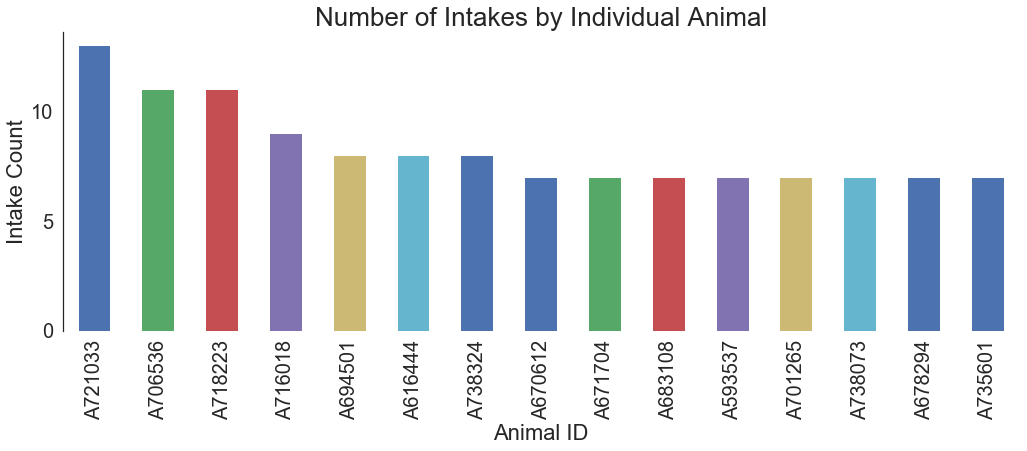

In [17]:
animal_intakes = intakes_df['animal_id'].value_counts()[0:15].plot(kind='bar', 
                                                                   fontsize=20,
                                                                   figsize=(15, 7))

animal_intakes.set_ylabel('Intake Count', fontsize=22)
animal_intakes.set_xlabel('Animal ID', fontsize=22)
animal_intakes.set_title('Number of Intakes by Individual Animal', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)

Some animals have been intaken into the shelter over ten times! The remaining top fifteen most frequently intaken animals hover around 6-8 intakes. Are animals often taken into the shelter more than once? Let's get the overall count of the frequency of intaken animals with the same unique id.

In [18]:
count = np.arange(2, 9)

intake_count = []
intake_name = []

for i in count:
    if i != 8:
        intakes = intakes_df['animal_id'].value_counts() == i
        intake_name.append(str(i) + ' Intakes')
    else:
        intakes = intakes_df['animal_id'].value_counts() >= i
        intake_name.append(str(i) + ' or Greater Intakes')
    
    intake_count.append(intakes.sum())
    

Construct a quick DataFrame to display the frequency of multiple intakes.

In [19]:
pd.DataFrame({'count': intake_count}, index=intake_name)

,count
2 Intakes,4976
3 Intakes,871
4 Intakes,199
5 Intakes,68
6 Intakes,24
7 Intakes,9
8 or Greater Intakes,7


About 6,100 animals out of the 80,000 records or about 7.63% in the dataset have been taken into the shelter more than once. This seems like a relatively high percentage given the overall number of records and intakes performed by the shelter. However, we don't have any comparison data to analyze if the number of multiple intakes is high, so for all we know this percentage could also be comparatively low.

Let's dig a little deeper into the subset of animals that have been intaken multiple times. We filter the intakes dataset for animal ids that appear more than once.

In [20]:
mult_intakes = intakes_df.loc[intakes_df['animal_id'].isin(intakes_df['animal_id'].value_counts()[intakes_df['animal_id'].value_counts() >= 2].index)].reset_index()

Using the filtered dataset, let's plot the animal and intake type to see if there are any significant differences.

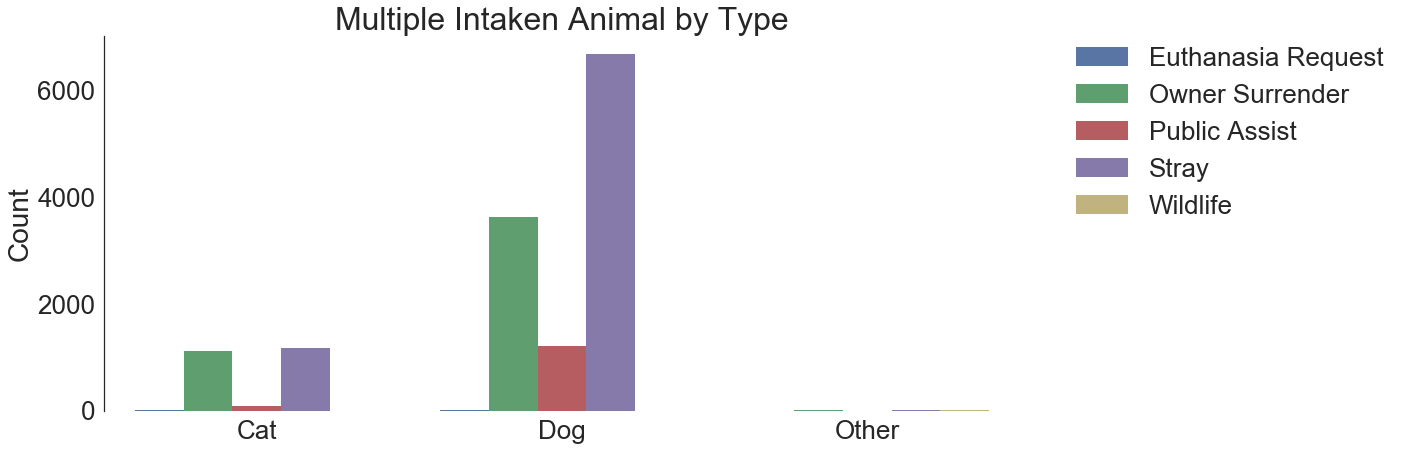

In [21]:
mult_intakes_types = pd.pivot_table(mult_intakes, 
                                   index=['animal_type', 'intake_type'],
                                    values=['count'], aggfunc=np.sum).reset_index()

plt.figure(figsize=(15, 7))

bar = sns.barplot(x='animal_type', y='count', hue='intake_type', data=mult_intakes_types)

bar.set_title('Multiple Intaken Animal by Type', fontsize=32)
bar.set_ylabel('Count', fontsize=28)

bar.axes.xaxis.label.set_visible(False)

bar.xaxis.labelpad = 10
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
sns.despine(bottom=True)

Stray dogs and, to a lesser extent, owner surrendered dogs, appear to represent the majority of animals intaken multiple times. Stray and owner-surrendered cats are about even regarding overall count but still are dwarfed by dogs intaken numerous times. We saw earlier that stray animal intakes were the most common type of intake received by the shelter, so it is not surprising to see stray intakes as a significant proportion of multiple intakes. However, this result seems to imply dogs that are released from the shelter have a higher chance to go stray or be surrendered by their owners compared to cats. As dogs are typically outdoors more often and therefore have a higher chance to go missing, as well as having a higher level of care required compared to cats (in general), perhaps this result isn't beyond a reasonable doubt. 

To identify animals that have been taken in multiple times and create a unique key, we add an `intake_number` column using [`rank()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rank.html) on the datetime of the intake. We then concatenate the original `animal_id` column with the newly created `intake_number` column to create a unique identifier column that will be useful in later analysis.

In [22]:
intakes_df.reset_index(inplace=True)

intakes_df['intake_number'] = intakes_df.groupby(['animal_id'])['intake_datetime'].rank(method='dense', ascending=False)
intakes_df['animal_id_new'] = intakes_df['animal_id'] + '_' + intakes_df['intake_number'].astype(int).astype(str)

## Conclusion

Through our exploratory analysis of the Austin Animal Center intakes dataset, we were able to reveal several exciting pieces of information about the animals intaken into the shelter. To briefly summarize some of what we uncovered:

* The overwhelming majority of intakes are stray dogs and cats within 2.5 years of age and in relatively healthy condition. Dogs are taken in more frequently than cats, which is interesting as one might reasonably expect there to be a more even split between dog and cat intakes. Particularly in a temperate and warm climate like Austin, where cats would be able to breed more often and more kittens surviving into adulthood. However, cats are much more difficult to capture than dogs (some live traps in use in trap-neuter-release programs can be set for days or weeks before a cat is caught), due to their size and ability to hide in smaller and more hidden spaces.
* Most cats and dogs taken to the shelter are not spayed or neutered, which given that the majority of intakes are strays, is not a surprise. Interestingly, the difference between spayed/neutered cats and dogs is much more prominent than intact intakes. Thus, it is much more likely that a cat intaken into the shelter will not be spayed or neutered. According to the Humane Society of America, [approximately 2 percent of community cats are spayed or neutered](http://www.humanesociety.org/issues/feral_cats/qa/feral_cat_FAQs.html). Given such a low proportion of spayed and neutered cats living outdoors, it is not unexpected to see comparatively low spayed/neutered cat intakes.
* There is not much difference in the volume of intakes over the course of a given week, though we do see overall intakes increase in May, June, and November. 'Kitten season' is typically in full swing by May and June, which could partially explain the increase. Most intakes are done between 11 am, and 4 pm, which is reasonable as intakes would be constrained by the hours the shelter is open.
* Stray and, to a lesser extent, wildlife intakes appear to peak in the beginning months of the year and then steadily decrease throughout the remainder of the year. Owner surrenders are relatively consistent in comparison, with some minor peaks and troughs in certain months.
* Dogs are more likely to return to the shelter either as a stray or as an owner surrender. Almost 8% of the animals intaken into the shelter were previously intaken.

In the next analysis, we combine the intakes and outcomes datasets provided by the Austin Animal Shelter to explore further into trends of what occurs during an animal's time in the shelter.

Lastly, save a copy of the dataset with the additional features we created during the analysis. We first delete the intermediate and no longer needed columns that were created during the analysis.

In [23]:
del intakes_df['datetime']
del intakes_df['datetime2']
del intakes_df['age_upon_intake_Periods']
del intakes_df['age_upon_intake_Period Range']
del intakes_df['month_start_end']

intakes_df.to_csv('../../../datasets/austin animal center intake outcomes/aac_intakes_transformed.csv')